#### Задание

Используя данные из обучающего датасета `train.csv`, построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета `test.csv`.

Целевая переменная: `Price`

Метрика качества: `R2` - коэффициент детерминации (`sklearn.metrics.r2_score`)

#### Требования к решению

1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin_predictions.csv. Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'AntonyanLS_predictions.csv'

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
# Функция преобразования категориальных переменных, если они принимают только два значения.
def obj_to_cat (columns, df):
    for column in columns:
        df[column] = df[column].replace({'A':0, 'B':1})

In [6]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

In [7]:
# Функция вырезает из выборки выбросы.
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [8]:
# Функция заменяет выбросы в выборке на среднее значение по признаку.
def replace_by_IQ(column, idf):
    IQ=idf[column].describe()['75%']-idf[column].describe()['25%']
    low_border=idf[column].describe()['25%']-IQ*1.5
    high_border=idf[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [9]:
# Функция заполняет пустые значения признака LifeSquare, высчитывая его через общую площадь квартиры.
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

In [10]:
# Функция заменяет выбросы признака HouseYear средним значением.
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [11]:
# Функция считает метрику r2_score и mae по переданным наборам данных и модели.
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [12]:
df.head()

Id  DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35   2.00   47.98       29.44           6.00      7   
1  15053          41   3.00   65.68       40.05           8.00      7   
2   4765          53   2.00   44.95       29.20           0.00      8   
3   5809          58   2.00   53.35       52.73           9.00      8   
4  10783          99   1.00   39.65       23.78           7.00     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        9.00       1969       0.09         B         B        33      7976   
1        9.00       1978       0.00         B         B        46     10309   
2       12.00       1968       0.05         B         B        34      7759   
3       17.00       1977       0.44         B         B        23      5735   
4       12.00       1976       0.01         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2      Price  
0         5           nan            0       11       B 184,966.93  
1         1        240.00            1       16       B 300,009.45  
2         0        229.00            1        3       B 220,925.91  
3         3      1,084.00            0        5       B 175,616.23  
4         1      2,078.00            2        4       B 150,226.53

#### Описание датасета

```
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 
```

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Целевая переменная

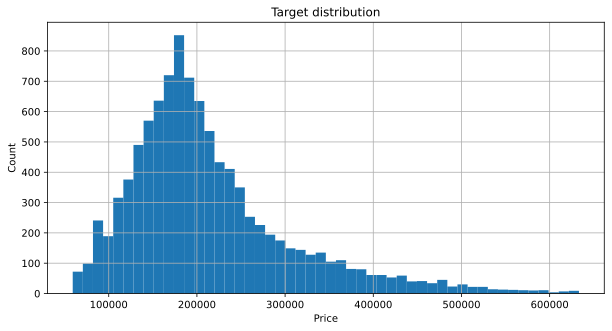

In [14]:
plt.figure(figsize = (10, 5))

df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution');

Датасет содержит три категориальных признака (`Ecology_2`, `Ecology_3`, `Shops_2`). По двум признакам есть пропущенные значения (`LifeSquare`, `Healthcare_1`). 

In [15]:
df['DistrictId'] = df['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

Сперва избавимся от категориальных признаков.

In [16]:
obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [17]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
174      1
209      1
205      1
196      1
Name: DistrictId, Length: 205, dtype: int64

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



Так как признаки принимают всего два значения, заменим их на 0 и 1.

In [18]:
obj_to_cat(obj_features, df)

In [19]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
174      1
209      1
205      1
196      1
Name: DistrictId, Length: 205, dtype: int64

1    9903
0      97
Name: Ecology_2, dtype: int64

1    9725
0     275
Name: Ecology_3, dtype: int64

1    9175
0     825
Name: Shops_2, dtype: int64



Признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.

In [20]:
 df.drop(['Healthcare_1'], axis=1, inplace=True)

Исследуем значения признаков `LifeSquare` и `Square`. Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

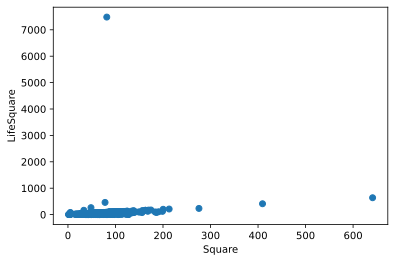

In [21]:
draw_scatter('Square', 'LifeSquare', df)

Оба признака имеют выбросы. Избавимся от них.

In [22]:
drop_by_IQ('Square', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.


In [23]:
drop_by_IQ('LifeSquare', df)

For column LifeSquare
	IQ:	21.75692564475336
	LOW:	-9.940131635100535
	HIGH:	77.08757094391291

Lost 1.91% of data.


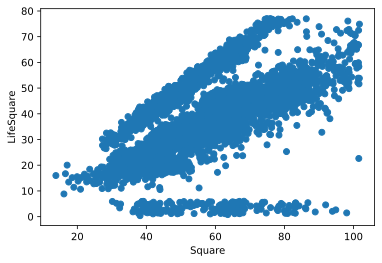

In [24]:
draw_scatter('Square', 'LifeSquare', df)

Видно, что теперь данные лежат намного кучнее

Найдём долю жилой площади от общей по средним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.

In [25]:
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378520569631749

In [26]:
fill_life_square(df, square_coeff)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9572 non-null   int64  
 1   DistrictId     9572 non-null   object 
 2   Rooms          9572 non-null   float64
 3   Square         9572 non-null   float64
 4   LifeSquare     9572 non-null   float64
 5   KitchenSquare  9572 non-null   float64
 6   Floor          9572 non-null   int64  
 7   HouseFloor     9572 non-null   float64
 8   HouseYear      9572 non-null   int64  
 9   Ecology_1      9572 non-null   float64
 10  Ecology_2      9572 non-null   int64  
 11  Ecology_3      9572 non-null   int64  
 12  Social_1       9572 non-null   int64  
 13  Social_2       9572 non-null   int64  
 14  Social_3       9572 non-null   int64  
 15  Helthcare_2    9572 non-null   int64  
 16  Shops_1        9572 non-null   int64  
 17  Shops_2        9572 non-null   int64  
 18  Price   

In [28]:
df.describe()

Id    Rooms   Square  LifeSquare  KitchenSquare    Floor  \
count  9,572.00 9,572.00 9,572.00    9,572.00       9,572.00 9,572.00   
mean   8,382.21     1.85    54.12       34.52           6.24     8.47   
std    4,856.60     0.81    15.59       13.03          29.07     5.17   
min        2.00     0.00    13.78        0.37           0.00     1.00   
25%    4,169.50     1.00    41.54       24.07           1.00     4.00   
50%    8,390.50     2.00    51.22       32.87           6.00     7.00   
75%   12,591.25     2.00    64.29       43.32           9.00    12.00   
max   16,798.00    19.00   102.03       77.05       2,014.00    42.00   

       HouseFloor     HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
count    9,572.00      9,572.00   9,572.00   9,572.00   9,572.00  9,572.00   
mean        12.59      4,079.25       0.12       0.99       0.97     24.91   
std          6.63    204,933.81       0.12       0.10       0.17     17.49   
min          0.00      1,910.00       0.00       0.00       0.00      0.00   
25%          9.00      1,973.00       0.02       1.00       1.00      6.00   
50%         12.00      1,977.00       0.08       1.00       1.00     25.00   
75%         17.00      1,999.00       0.20       1.00       1.00     36.00   
max        117.00 20,052,011.00       0.52       1.00       1.00     74.00   

       Social_2  Social_3  Helthcare_2  Shops_1  Shops_2      Price  
count  9,572.00  9,572.00     9,572.00 9,572.00 9,572.00   9,572.00  
mean   5,390.69      8.03         1.33     4.24     0.92 209,182.37  
std    3,994.35     23.70         1.49     4.79     0.27  87,271.97  
min      168.00      0.00         0.00     0.00     0.00  59,174.78  
25%    1,564.00      0.00         0.00     1.00     1.00 151,904.42  
50%    5,285.00      2.00         1.00     3.00     1.00 189,610.14  
75%    7,287.00      5.00         2.00     6.00     1.00 244,221.52  
max   19,083.00    141.00         6.00    23.00     1.00 633,233.47

Признак KitchenSquare содержит выбросы. Избавимся от них.

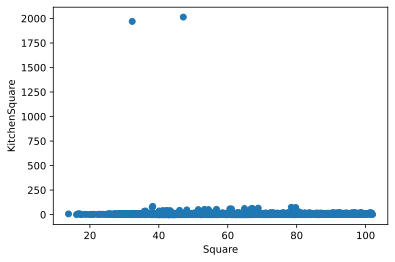

In [29]:
draw_scatter('Square', 'KitchenSquare', df)

In [30]:
replace_by_IQ('KitchenSquare', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


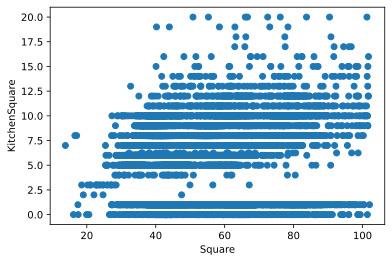

In [31]:
draw_scatter('Square', 'KitchenSquare', df)

Взглянем так же на комнаты. Видно, что присутствуют выбросы.

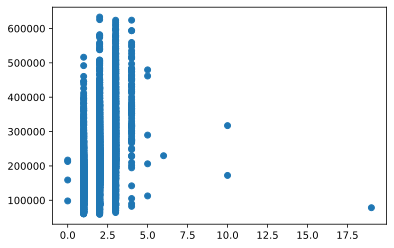

In [32]:
plt.scatter(df['Rooms'], df['Price']);

обработаем их.

In [33]:
df.loc[(df['Rooms'] > 5)|(df['Rooms'] == 0), 'Rooms'] = df['Rooms'].mode()[0]
test.loc[(test['Rooms'] > 5)|(test['Rooms'] == 0), 'Rooms'] = df['Rooms'].mode()[0]

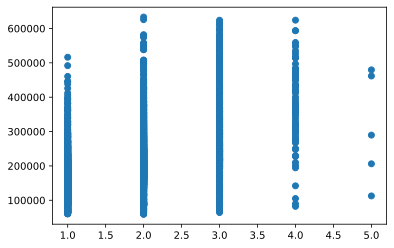

In [34]:
plt.scatter(df['Rooms'], df['Price']);

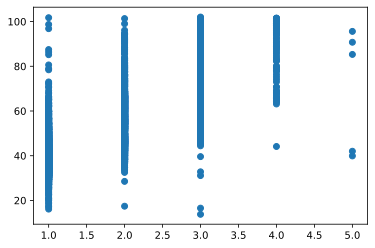

In [35]:
plt.scatter(df['Rooms'], df['Square']);

Признак HouseYear так же содержит выпадающие значения. Обработаем их.

In [36]:
mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [37]:
clean_year(df, mean_year)

Ещё раз взглянем на получившийся датасет.

In [38]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id'], axis=1)

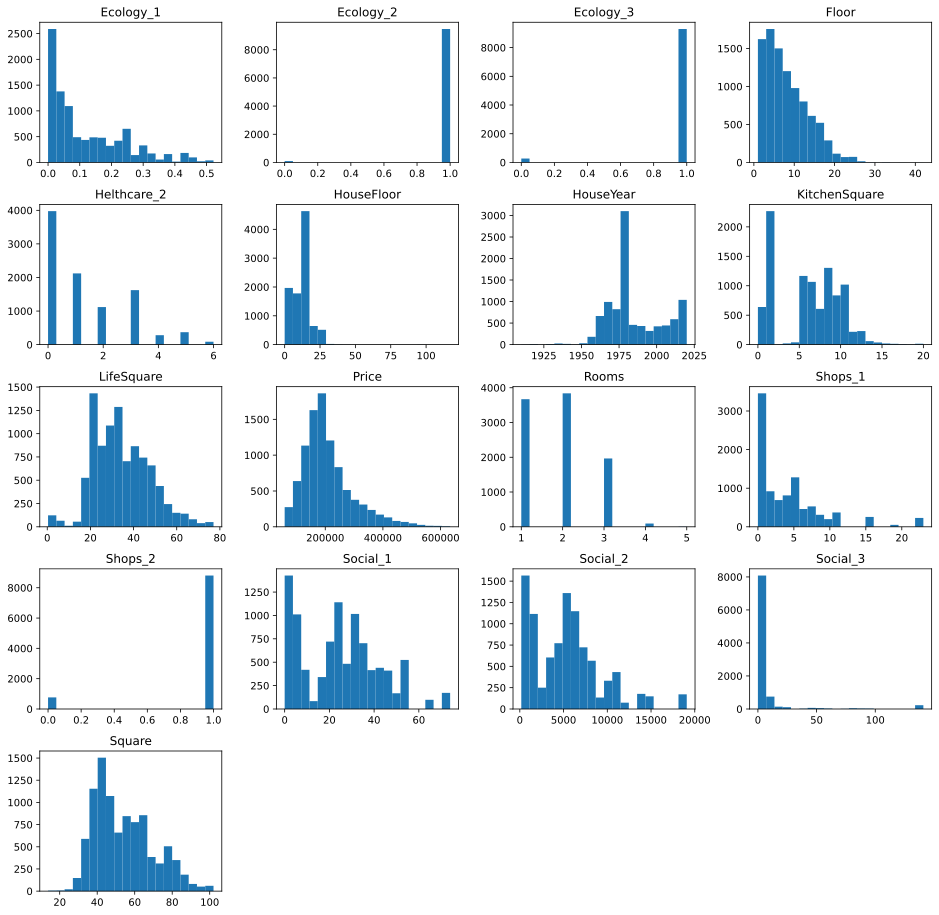

In [39]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [40]:
obj_to_cat(obj_features, test)
test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)
fill_life_square(test, square_coeff)
replace_by_IQ('KitchenSquare', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	54.11885944248657
In 0 row Square was replaced to 54.11885944248657.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	34.51982581589088
In 0 row LifeSquare was replaced to 34.51982581589088.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.701163419511815
In 0 row KitchenSquare was replaced to 5.701163419511815.


Разобьем тестовый датасет на тестовый и валидационный.

In [41]:
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [42]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
X_test = test[features]
X_test.head()

Rooms  Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0   2.00   49.88       33.43           6.00      6       14.00       1972   
1   2.00   69.26       44.18           1.00      6        1.00       1977   
2   1.00   13.60       15.95          12.00      2        5.00       1909   
3   2.00   73.05       51.94           9.00     22       22.00       2007   
4   1.00   47.53       43.39           1.00     17       17.00       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0       0.31          1          1        11      2748         1            0   
1       0.08          1          1         6      1437         3            0   
2       0.00          1          1        30      7538        87            5   
3       0.10          1          1        23      4583         3            3   
4       0.07          1          1         2       629         1            0   

   Shops_1  Shops_2  
0        0        1  
1        2        1  
2        5        1  
3        3        1  
4        0        0

Масштабируем данные.

In [45]:
scaler = StandardScaler()

In [46]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

Для обучения была использована модель RandomForestRegressor с параметрами n_estimators=1000, max_depth=9, max_features=7, random_state=42.

In [47]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.8178129809932618, mae_train: 24437.339434193145
r2_test = 0.6802312536510229, mae_test: 30115.769958924942


In [48]:
price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)